# Grid-World Problem

In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import gymnasium as gym
from gymnasium import Env
import matplotlib.pyplot as plt
from environments import ModelBasedEnv, ModelFreeEnv
from agents import Agent, EpsilonGreedyAgent, UcbAgent
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

RUNS=20
EPSILON=-1
SEED = 123
MAP_SIZE = 8 
EPISODES=1000
FROZEN_PROB = 0.8
LEARNING_RATE=0.8
DISCOUNT_FACTOR = 0.95
CONVERGENCE_RANGE = 0.001

random.seed(SEED)
np.random.seed(SEED)
rng = np.random.default_rng(SEED)

# Gridworld Environment

We'll be using Openai's Frozenlake environment underneath

In [2]:

class GridWorld(ModelBasedEnv):
    def __init__(self, env: Env) -> None:
        super().__init__(env.observation_space.n, env.action_space.n)
        self.env: Env = env
        self.reset()

    def step(self, state, action):
        new_state, _, terminated, truncated, _ = self.env.step(action)
        return new_state, self.reward(state, action, new_state), (terminated or truncated)

    def action_space(self):
        return range(self.env.action_space.n)
    
    def state_space(self):
        return range(self.env.observation_space.n)
    
    def reset(self):
        return self.env.reset(seed=SEED)[0]  # Reset the environment

    def is_terminal(self, state):
        layout = self.env.desc.tolist()
        row = state // len(layout[0])  # Integer division to get the row index
        col = state % len(layout[0]) 
        return layout[row][col] == b'G'
    
    def is_obstacle(self, state):
        layout = self.env.desc.tolist()
        row = state // len(layout[0])  # Integer division to get the row index
        col = state % len(layout[0]) 
        return layout[row][col] == b'H'
    
    def transitions(self, state, action):
        transitions = self.env.P[state][action]
        return [(prob_tuple[1], prob_tuple[0]) for prob_tuple in transitions]

    def reward(self, state, action, next_state):
        if self.is_terminal(next_state):
            return 10   # Reward for reaching the goal
        elif self.is_obstacle(next_state):
            return -10  # Penalty for falling into a hole
        else:
            return -1   # Penalty for each step

# Visualization Methods

In [3]:
def qvalue_directions_map(qtable):
    qtable_val_max = qtable.max(axis=1).reshape(MAP_SIZE, MAP_SIZE)
    qtable_best_action = np.argmax(qtable, axis=1).reshape(MAP_SIZE, MAP_SIZE)
    directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    # Minimum float number on the machine
    eps = np.finfo(float).eps  
    for idx, val in enumerate(qtable_best_action.flatten()):
        if qtable_val_max.flatten()[idx] > eps:
            qtable_directions[idx] = directions[val]
    qtable_directions = qtable_directions.reshape(MAP_SIZE, MAP_SIZE)
    return qtable_val_max, qtable_directions

def plot_q_values_map(qtable, env):
    qtable_val_max, qtable_directions = qvalue_directions_map(qtable)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax[0].imshow(env.render())
    ax[0].axis("off")
    ax[0].set_title("Frozenlake Environment")

    # Plot the policy
    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        ax=ax[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title="Q-values\n(arrows represent best action)")
    for _, spine in ax[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")    

    plt.show()

def postprocess(rewards, steps):
    episodes = np.arange(EPISODES)
    """Convert the results of the simulation in dataframes."""
    res = pd.DataFrame(
        data={
            "Episodes": episodes,
            "Rewards": rewards.mean(axis=1),
            "Steps": steps.mean(axis=1),
        }
    )
    res["cum_rewards"] = rewards.mean(axis=1)
    st = pd.DataFrame(data={"Episodes": episodes, "Steps": steps.mean(axis=1)})
    return res, st

def plot_actions_distribution(actions):
    """Plot the distribution of actions."""
    labels = {"LEFT": 0, "DOWN": 1, "RIGHT": 2, "UP": 3}

    fig, ax = plt.subplots(figsize=(7.5, 5))
    sns.histplot(data=actions, ax=ax)
    ax.set_xticks(list(labels.values()), labels=labels.keys())
    ax.set_title("Actions")
    fig.tight_layout()
    plt.show()

def plot_steps_and_rewards(rewards_df, steps_df):
    """Plot the steps and rewards from dataframes."""
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.lineplot(
        data=rewards_df, x="Episodes", y="cum_rewards", ax=ax[0]
    )
    ax[0].set(ylabel="Cumulated rewards")

    sns.lineplot(data=steps_df, x="Episodes", y="Steps", ax=ax[1])
    ax[1].set(ylabel="Averaged steps number")

    fig.tight_layout()
    plt.show()

In [4]:
env = gym.make(
    "FrozenLake-v1",
    is_slippery=False,
    render_mode="rgb_array",
    desc=generate_random_map(
        size=MAP_SIZE, p=FROZEN_PROB, seed=SEED
    ),
)

gridworld = GridWorld(env)

# VALUE ITERATION

Use the value iteration algorithm to find the optimal policy and action-value function

In [5]:
value = np.zeros(gridworld.state_size)
qvalue = np.zeros((gridworld.state_size, gridworld.action_size))
policy = np.zeros(gridworld.state_size, dtype=int)
while True:
    delta = 0.0
    for state in gridworld.state_space():
        for action in gridworld.action_space():
            # Calculate the value of Q(s,a) 
            new_value = 0.0
            for (new_state, probability) in gridworld.transitions(
                state, action
            ):
                reward = gridworld.reward(state, action, new_state)
                new_value += probability * (
                    reward
                    + (
                        DISCOUNT_FACTOR * value[new_state]
                    )
                )
            qvalue[state, action] = new_value

        # V(s) = max_a Q(s,a)
        max_q = max(qvalue[state])
        delta = max(delta, abs(value[state] - max_q))
        value[state] = max_q

        # π(s) = argmax_a Q(s,a)
        policy[state] = np.argmax(qvalue[state])

    # Terminate if the value function has converged
    if delta < CONVERGENCE_RANGE:
        break

for action in gridworld.action_space():
    qvalue[state, action] = min(value)

c:\class\reinforcement-learning\Assignment I\.venv\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.P to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.P` for environment variables or `env.get_wrapper_attr('P')` that will search the reminding wrappers.
  logger.warn(
c:\class\reinforcement-learning\Assignment I\.venv\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.desc to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.desc` for environment variables or `env.get_wrapper_attr('desc')` that will search the reminding wrappers.
  logger.warn(


### Q-Value & Policy Visualization

Let's visualize the optimal action-value & policy that is found using the value iteration starting from a randomly(zeros) initialized action-value function

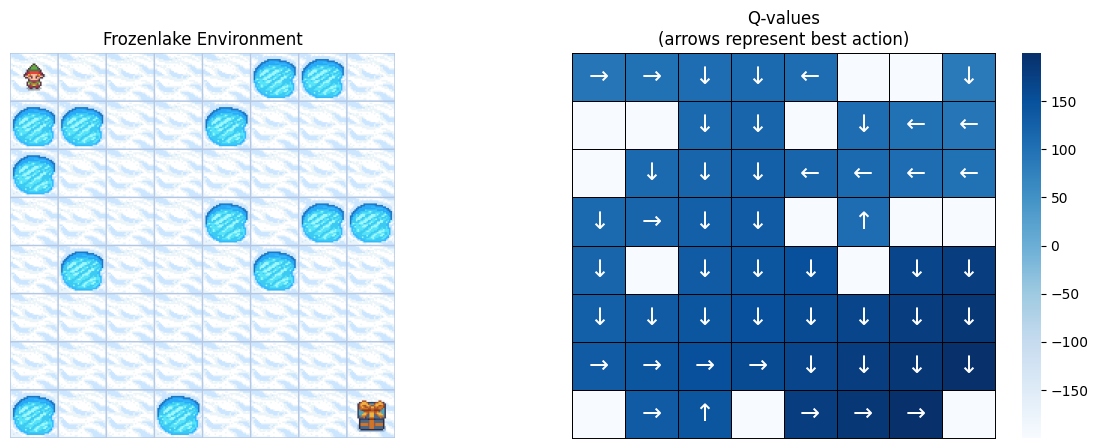

In [6]:
plot_q_values_map(qvalue, env)

As expected the action-value function that converged provides the right direction to the goal. And as expected no actions are taken on the holes in the grid

# POLICY ITERATION

Use the policy iteration algorithm to find the optimal policy and optimal action-value function starting from randomly initialized policy

In [7]:
gridworld.reset()

def value_extraction(env: ModelBasedEnv, policy: np.ndarray[int], gamma, theta):
    value = np.zeros(env.state_size)
    while True:
        delta = 0
        for state in range(env.state_size):
            old_value = value[state]
            action = policy[state]
            new_value = 0.0
            for (s_prime, probability) in env.transitions(
                state, action
            ):
                new_value += probability * (env.reward(state, action, s_prime) + gamma * value[s_prime]) 
                
            value[state] = new_value
            delta = max(delta, abs(old_value - new_value))
        if delta < theta:
            break
    return value

def policy_update(env: ModelBasedEnv, value: np.ndarray[int], gamma: float) -> np.ndarray[int]:
    qvalues = np.zeros((env.state_size, env.action_size))
    policy = np.zeros(env.state_size, dtype=int)
    for s in env.state_space():
        for a in env.action_space():
            q_value = 0.0
            for (s_prime, probability) in env.transitions(s, a):
                q_value += probability * (env.reward(s, a, s_prime) + gamma * value[s_prime])
            qvalues[s, a] = q_value
        policy[s] = np.argmax(qvalues[s])
    return policy, qvalues

policy = np.zeros(gridworld.state_size, dtype=int)
while True:
    value = value_extraction(gridworld, policy, DISCOUNT_FACTOR, CONVERGENCE_RANGE)
    new_policy, qvalue = policy_update(gridworld, value, DISCOUNT_FACTOR)
    if np.array_equal(policy, new_policy):
        break
    policy = new_policy

c:\class\reinforcement-learning\Assignment I\.venv\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.P to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.P` for environment variables or `env.get_wrapper_attr('P')` that will search the reminding wrappers.
  logger.warn(
c:\class\reinforcement-learning\Assignment I\.venv\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.desc to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.desc` for environment variables or `env.get_wrapper_attr('desc')` that will search the reminding wrappers.
  logger.warn(


### Q-value & Policy Visualization

Let's visualize the optimal action-value & policy that is found using the policy iteration starting from a randomly(zeros) initialized policy

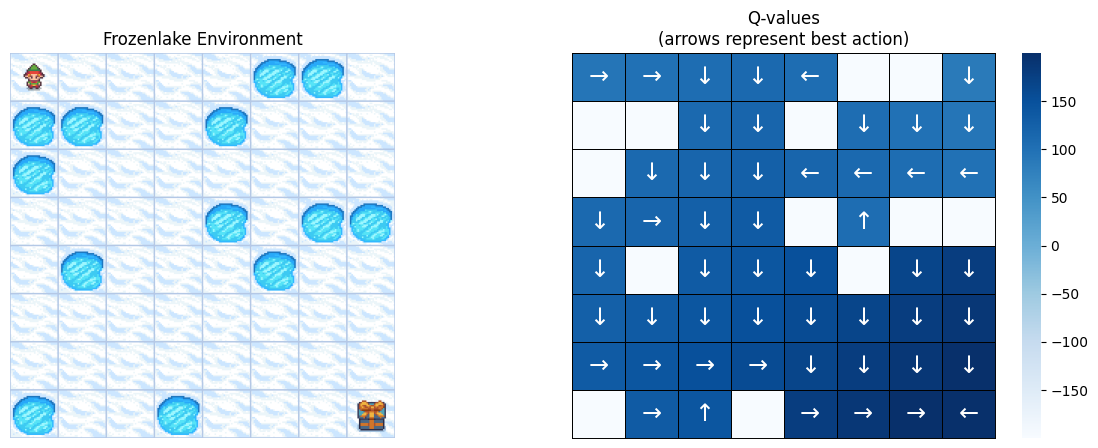

In [8]:
plot_q_values_map(qvalue, env)

# Q-LEARNING

In [9]:
class QlearningAgent(Agent):
    def __init__(self, env: ModelBasedEnv, learning_rate: float, discount_factor: float) -> None:
        super().__init__(env)
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor

    def update(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_value[next_state])
        td_target = reward + self.discount_factor * self.q_value[next_state, best_next_action]
        td_error = td_target - self.q_value[state, action]
        self.q_value[state, action] += self.learning_rate * td_error

class QlearningEpGreedyAgent(QlearningAgent, EpsilonGreedyAgent):
    pass
    
class QlearningUcbAgent(QlearningAgent, UcbAgent):
    pass


In [10]:
def run_experiment(env: ModelFreeEnv, agent: Agent):
    episodes = np.arange(EPISODES)
    actions_history = []
    steps = np.zeros((EPISODES, RUNS))
    rewards = np.zeros((EPISODES, RUNS))
    qvalues = np.zeros((RUNS, env.state_size, env.action_size))

    # Run several times to account for stochasticity
    for run in range(RUNS):  
        agent.reset()
        for episode in tqdm(
            episodes, desc=f"Run {run}/{RUNS} - Episodes", leave=False
        ):
            step = 0
            done = False
            total_rewards = 0
            state = env.reset()

            while not done:
                action = agent.select_action(state)

                actions_history.append(action)

                new_state, reward, done = env.step(state, action)

                agent.update(state, action, reward, new_state)

                total_rewards += reward
                step += 1

                state = new_state

            rewards[episode, run] = total_rewards
            steps[episode, run] = step
        qvalues[run, :, :] = np.copy(agent.q_value)

    return rewards, steps, qvalues, actions_history

## Q-Learning with Epsilon-Greedy Strategy

In [11]:
gridworld.reset()
agent = QlearningEpGreedyAgent(env=gridworld, learning_rate=LEARNING_RATE, discount_factor=DISCOUNT_FACTOR)
rewards, steps, qvalues, actions_history = run_experiment(gridworld, agent)

Run 0/20 - Episodes:   0%|          | 0/1000 [00:00<?, ?it/s]

c:\class\reinforcement-learning\Assignment I\.venv\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.desc to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.desc` for environment variables or `env.get_wrapper_attr('desc')` that will search the reminding wrappers.
  logger.warn(


In [12]:
res_all = pd.DataFrame()
st_all = pd.DataFrame()
res, st = postprocess(rewards, steps)
res_all = pd.concat([res_all, res])
st_all = pd.concat([st_all, st])
avg_qvalue = qvalues.mean(axis=0)  # Average the Q-table between runs

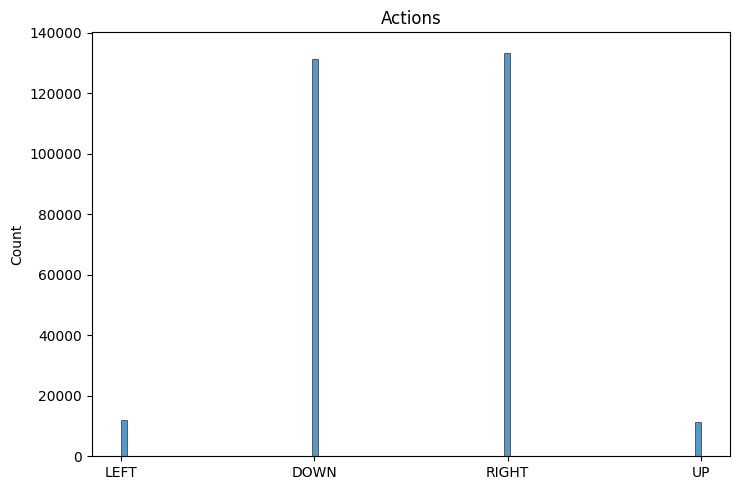

In [13]:
plot_actions_distribution(actions_history)

Most of the actions taken by the agent is down and right which makes sense because the goal is in the bottom right corner of the grid. This indicates that the action-value function updated by the algorithm is an indeed optimal

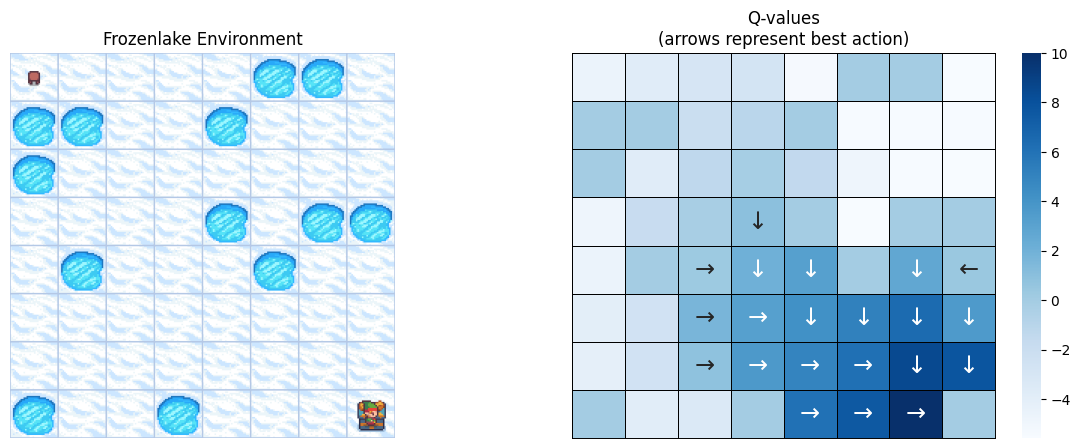

In [14]:
plot_q_values_map(avg_qvalue, env)

To check if our agent is learning, we want to plot the cumulated sum of
rewards, as well as the number of steps needed until the end of the
episode. If our agent is learning, we expect to see the cumulated sum of
rewards to increase and the number of steps to solve the task to
decrease.


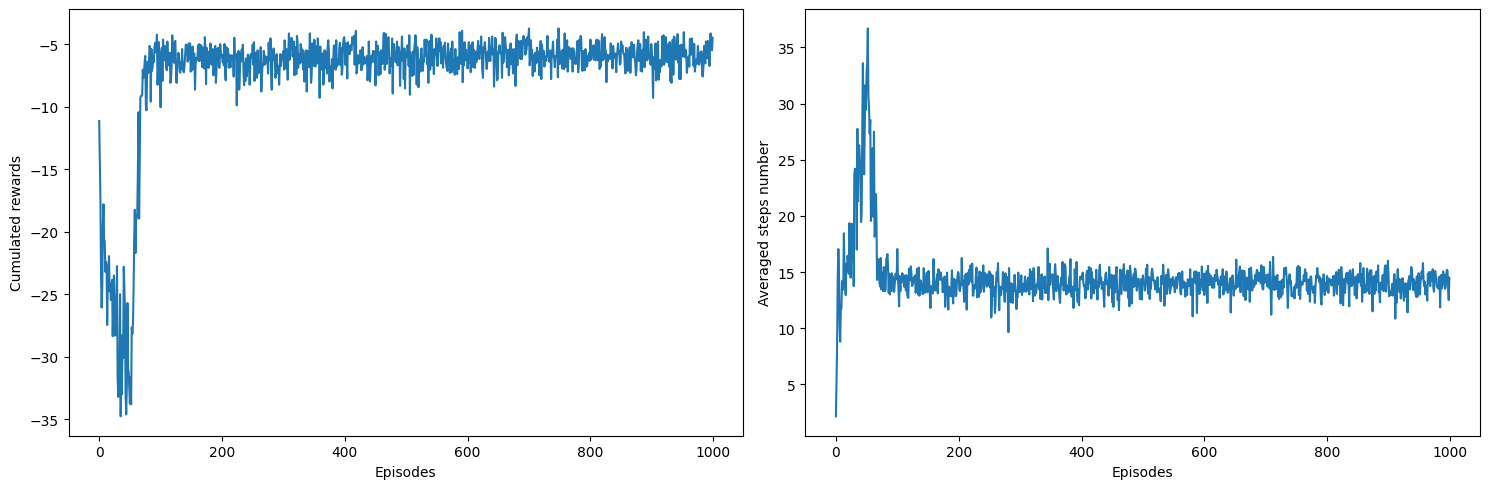

In [15]:
plot_steps_and_rewards(res_all, st_all)

As expected the agent stumbled on earlier episodes but through interaction with the environment, the cumulative reward increased and the number of steps taken by the agent decreased and both curves plateau at a fixed value

## Q-Learning with Upper Confidence Bound

In [16]:
gridworld.reset()
agent = QlearningUcbAgent(gridworld, LEARNING_RATE, DISCOUNT_FACTOR)
rewards, steps, qvalues, actions_history = run_experiment(gridworld, agent)

Run 0/20 - Episodes:   0%|          | 0/1000 [00:00<?, ?it/s]

c:\class\reinforcement-learning\Assignment I\.venv\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.desc to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.desc` for environment variables or `env.get_wrapper_attr('desc')` that will search the reminding wrappers.
  logger.warn(


In [17]:
res, st = postprocess(rewards, steps)
res_all = pd.concat([res_all, res])
st_all = pd.concat([st_all, st])
avg_qvalue = qvalues.mean(axis=0)  # Average the Q-table between runs

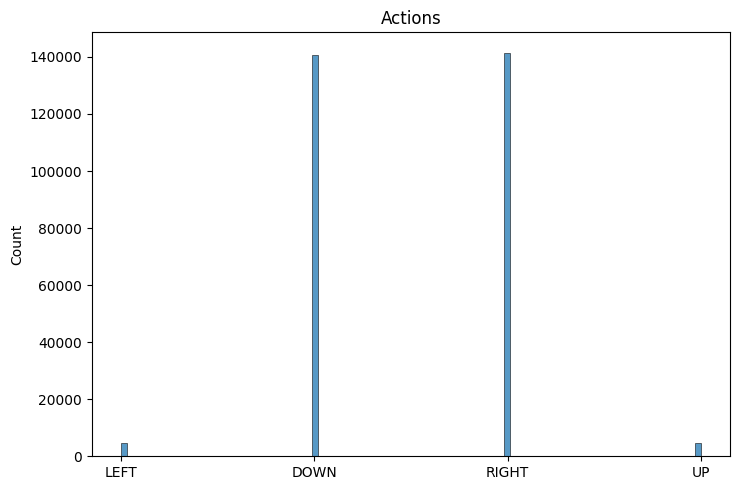

In [18]:
plot_actions_distribution(actions_history)

Most of the actions taken by the agent is down and right which makes sense because the goal is in the bottom right corner of the grid. This indicates that the action-value function updated by the algorithm is an indeed optimal

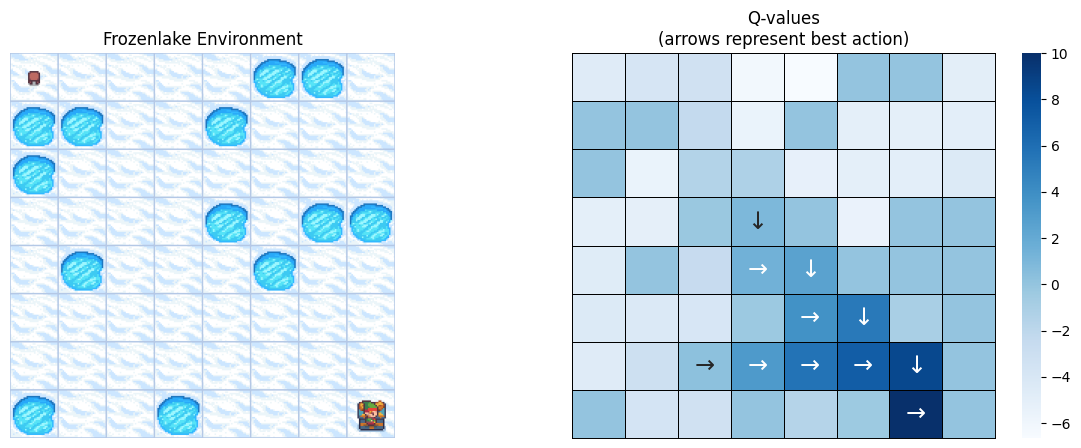

In [19]:
plot_q_values_map(avg_qvalue, env)

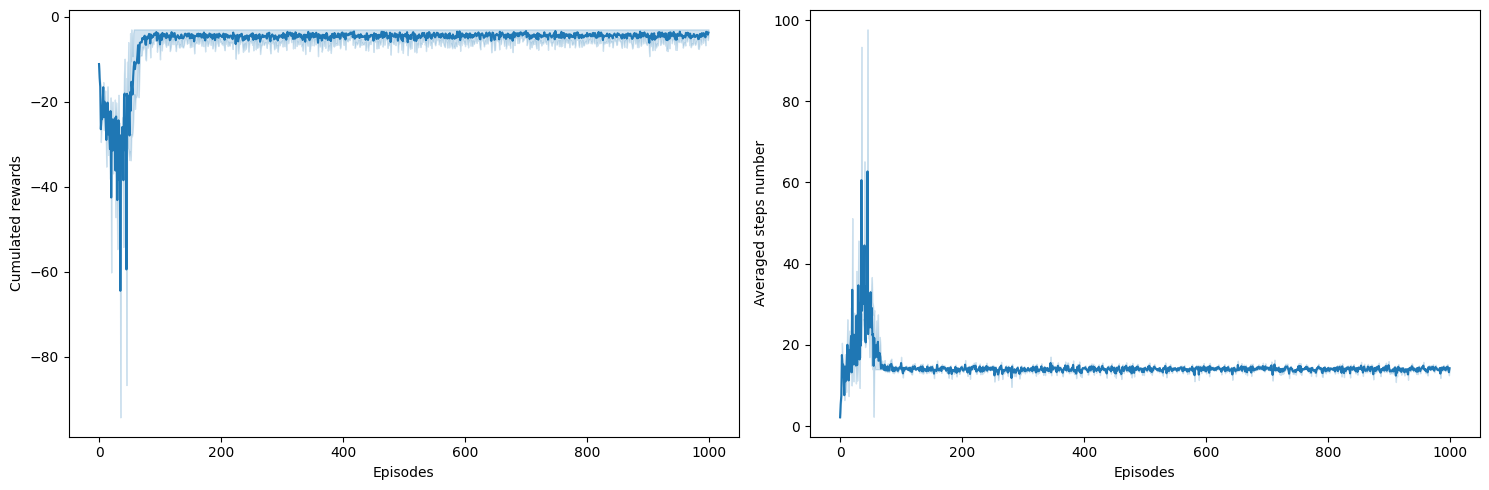

In [20]:
plot_steps_and_rewards(res_all, st_all)

As expected the agent stumbled on earlier episodes but through interaction with the environment, the cumulative reward increased and the number of steps taken by the agent decreased and both curves plateau at a fixed value